# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Finding-HIF-1-direct-target-candidates" data-toc-modified-id="Finding-HIF-1-direct-target-candidates-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Finding HIF-1 direct target candidates</a></div><div class="lev1 toc-item"><a href="#vhl-1-dependent,-hif-1-independent,-genes" data-toc-modified-id="vhl-1-dependent,-hif-1-independent,-genes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span><em>vhl-1</em> dependent, <em>hif-1</em>-independent, genes</a></div><div class="lev2 toc-item"><a href="#Plot-vhl-1-dependent,-hif-1-independent-genes" data-toc-modified-id="Plot-vhl-1-dependent,-hif-1-independent-genes-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Plot <em>vhl-1</em>-dependent, <em>hif-1</em>-independent genes</a></div>

In this notebook, I will identify gene targets that are specifically regulated by each *egl-9*, *vhl-1*, and *hif-1*. I define a specific regulatory node to mean the node that is the nearest regulatory node to these targets out of the subset of genes we have mutants for. As usual, we first load up all the libraries

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

# morgan
import tissue_enrichment_analysis as tea
import epistasis as epi
import genpy
import gvars

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
q = 0.1
genvar = gvars.genvars()
tissue_df = tea.fetch_dictionary()
phenotype_df = pd.read_csv('../input/phenotype_ontology.csv')
go_df = pd.read_csv('../input/go_dictionary.csv')

In [3]:
tidy_data = pd.read_csv('../output/temp_files/DE_genes.csv')
tidy_data.sort_values('target_id', inplace=True)
tidy_data.dropna(subset=['ens_gene'], inplace=True)
tidy_data['fancy genotype'] = tidy_data.code.map(genvar.fancy_mapping)
tidy_data = tidy_data[tidy_data.genotype != 'fog-2']
tidy_data.head()

,ens_gene,ext_gene,target_id,b,se_b,qval,genotype,sorter,code,fancy genotype
0,WBGene00007064,2RSSE.1,2RSSE.1a,1.121038,0.586487,0.216276,egl-9;vhl-1,6,a,\emph{egl-9;vhl-1}
19676,WBGene00007064,2RSSE.1,2RSSE.1a,0.524134,0.586487,0.887525,egl-9 hif-1,7,f,\emph{egl-9 hif-1}
118056,WBGene00007064,2RSSE.1,2RSSE.1a,0.519789,0.586487,0.791051,hif-1,4,c,\emph{hif-1}
98380,WBGene00007064,2RSSE.1,2RSSE.1a,0.934036,0.586487,0.409735,egl-9,2,b,\emph{egl-9}
59028,WBGene00007064,2RSSE.1,2RSSE.1a,0.809959,0.586487,0.496563,rhy-1,1,e,\emph{rhy-1}


# Finding HIF-1 direct target candidates

We are interested in identifying gene targets of HIF-1. In order to do this, I will decouple my data into two parts:
 * a `positive` dataframe, which contains all genes with $\beta$ values greater than 0
 * a `negative` dataframe, which contains all genes with $\beta$ values less than 0
 
I will also define a function called `collate`. This function takes in a list or a numpy array and returns a boolean indicator of what genes are in a specified dataframe. It's a lot shorter to define this function than it is to write the one-liner over and over again.

In [4]:
def collate(x):
    """For a vector `x`, find what elements in x are contained in
       tidy_data.target_id."""
    return tidy_data.target_id.isin(x)

In [5]:
hif_genes = pd.read_csv('../output/temp_files/hypoxia_response.csv')

n = len(hif_genes[hif_genes.b > 0].ens_gene.unique())
message = 'There are {0} unique genes that' +\
          ' are candidates for HIF-1 direct binding'
print(message.format(n))

There are 1173 unique genes that are candidates for HIF-1 direct binding


As a safety check, let's make a qPCR like plot to visualize our genes, and let's make sure they have the behavior we want:

In [6]:
ids = hif_genes[hif_genes.b > 0].target_id
hypoxia_direct_targets = tidy_data[tidy_data.target_id.isin(ids)]

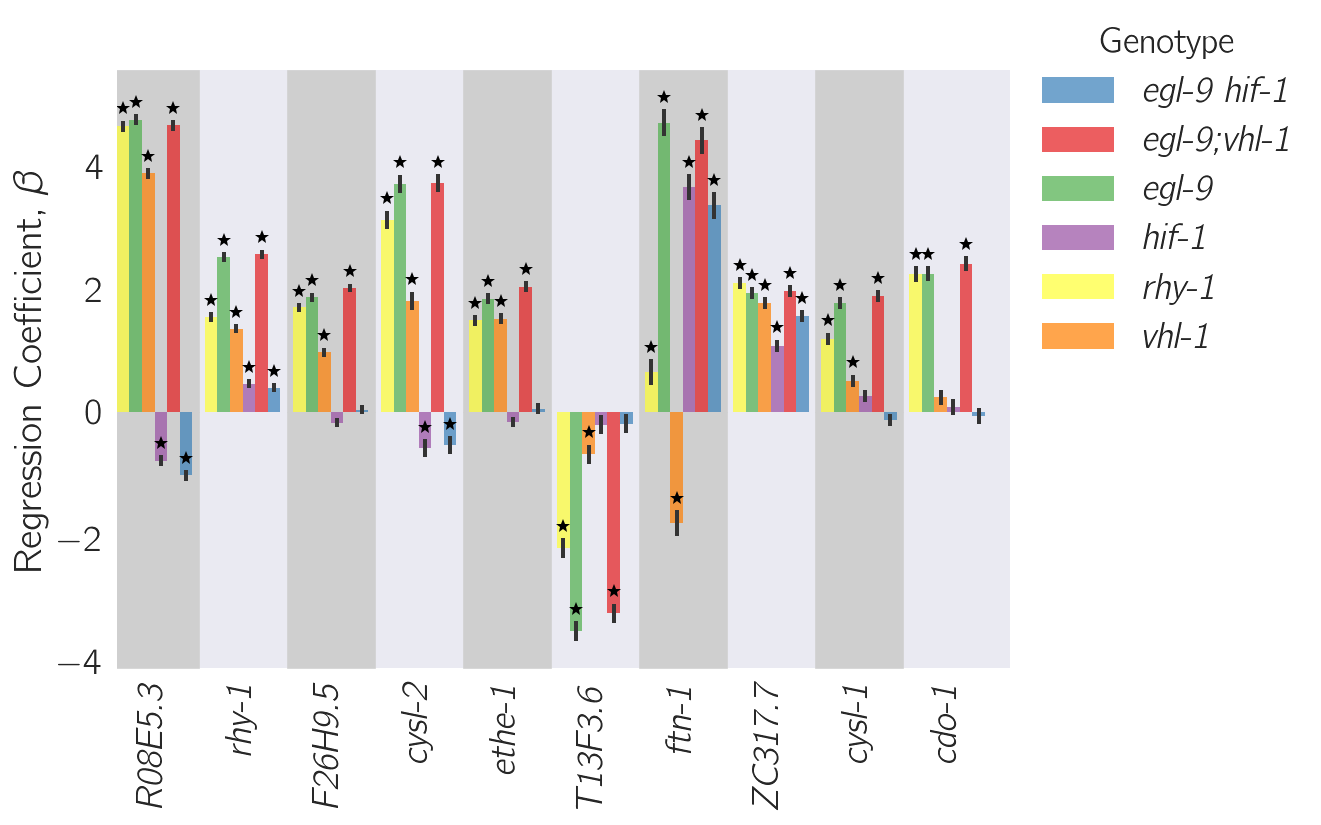

In [7]:
names = hypoxia_direct_targets.sort_values('qval').target_id.unique()[0:10]

name_sort = {}
for i, name in enumerate(names):
    name_sort[name] = i+1

plot_df = tidy_data[tidy_data.target_id.isin(names)].copy()
plot_df['order'] = plot_df.target_id.map(name_sort)
plot_df.sort_values('order', inplace=True)
plot_df.reset_index(inplace=True)  

genpy.qPCR_plot(plot_df, genvar.plot_order, genvar.plot_color,
                clustering='fancy genotype', plotting_group='target_id',
                rotation=90)

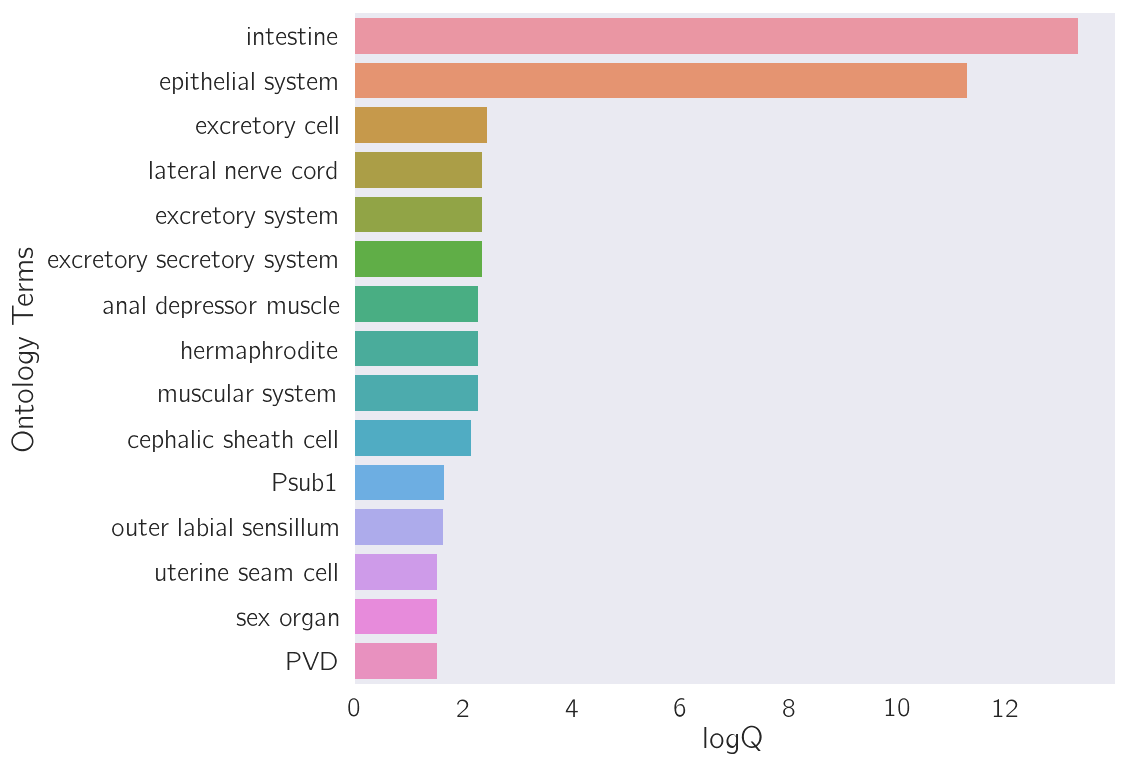

In [8]:
res = tea.enrichment_analysis(hypoxia_direct_targets.ens_gene.unique(),
                              tissue_df, show=False)
res['logQ'] = -res['Q value'].apply(np.log10)
tea.plot_enrichment_results(res, analysis='tissue', y='logQ')

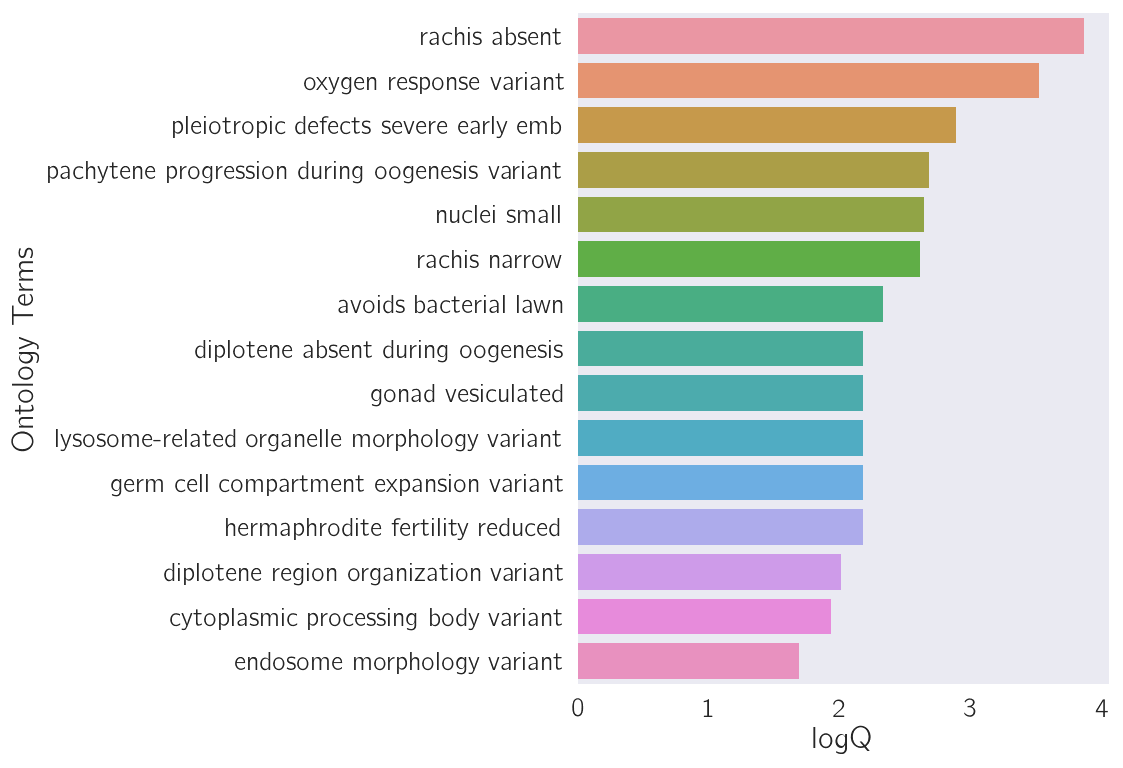

In [9]:
res = tea.enrichment_analysis(hypoxia_direct_targets.ens_gene.unique(),
                            phenotype_df, show=False)
res['logQ'] = -res['Q value'].apply(np.log10)
tea.plot_enrichment_results(res, analysis='phenotype', y='logQ')

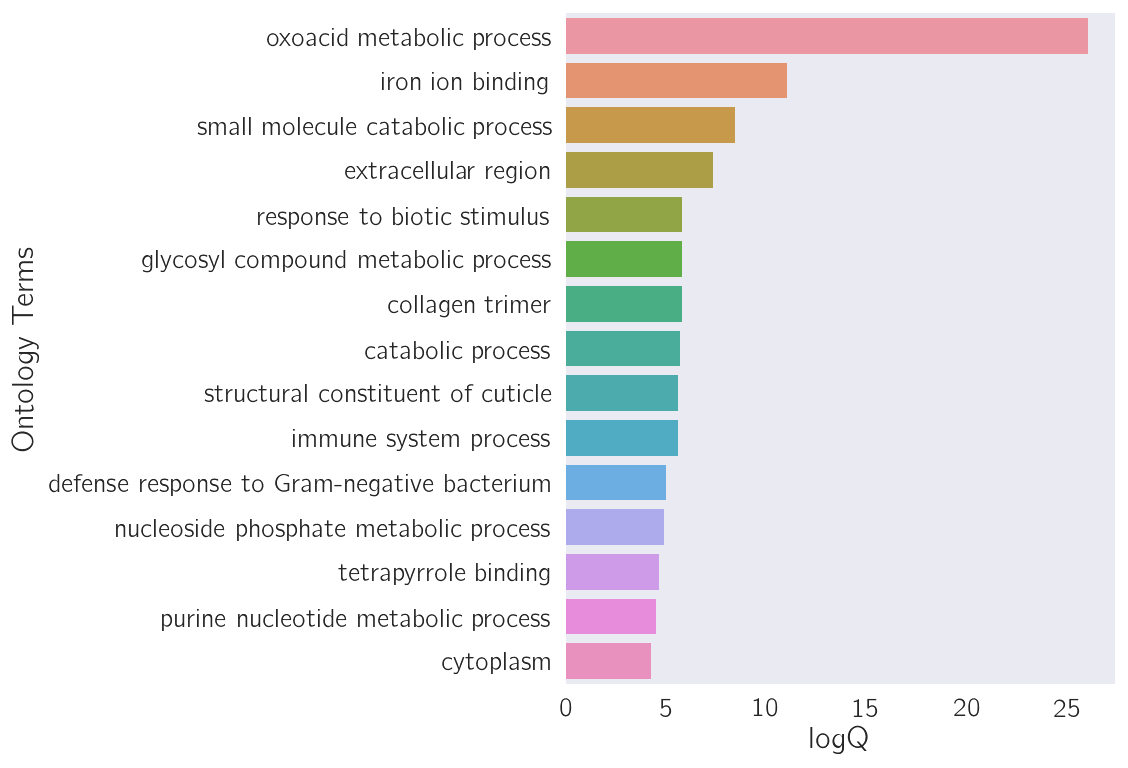

In [10]:
res = tea.enrichment_analysis(hypoxia_direct_targets.ens_gene.unique(),
                              go_df, show=False)
res['logQ'] = -res['Q value'].apply(np.log10)
tea.plot_enrichment_results(res, analysis='go', y='logQ')

# *vhl-1* dependent, *hif-1*-independent, genes

We can gate our settings to observe only *vhl-1*-dependent genes, by selecting only those genes that were present in the *vhl-1* and *egl-9;vhl-1* genotypes.

In [11]:
positive = tidy_data[(tidy_data.qval < q) & (tidy_data.b > 0)]
negative = tidy_data[(tidy_data.qval < q) & (tidy_data.b < 0)]

# find the genes that overlap between vhl1 and egl-9vhl-1 and change in
# same directiom
vhl_pos = epi.find_overlap(['d', 'a'], positive)
vhl_neg = epi.find_overlap(['d', 'a'], negative)
vhl = list(set(vhl_pos + vhl_neg))

# find genes that change in the same direction in vhl(-) and
# vhl(+ datasets)
same_vhl = []
for genotype in ['b', 'e', 'f', 'c']:
    same_vhl += epi.find_overlap(['d', 'a', genotype], positive)
    same_vhl += epi.find_overlap(['d', 'a', genotype], negative)

# put it all together:
ind = (collate(vhl)) & (~collate(same_vhl))
vhl_regulated = tidy_data[ind & (tidy_data.code == 'd')]

n = len(vhl_regulated.ens_gene.unique())
message = 'There are {0} genes that appear to be ' + \
          'regulated in a hif-1-independent, vhl-1-dependent manner.'
print(message.format(n))

There are 72 genes that appear to be regulated in a hif-1-independent, vhl-1-dependent manner.


## Plot *vhl-1*-dependent, *hif-1*-independent genes

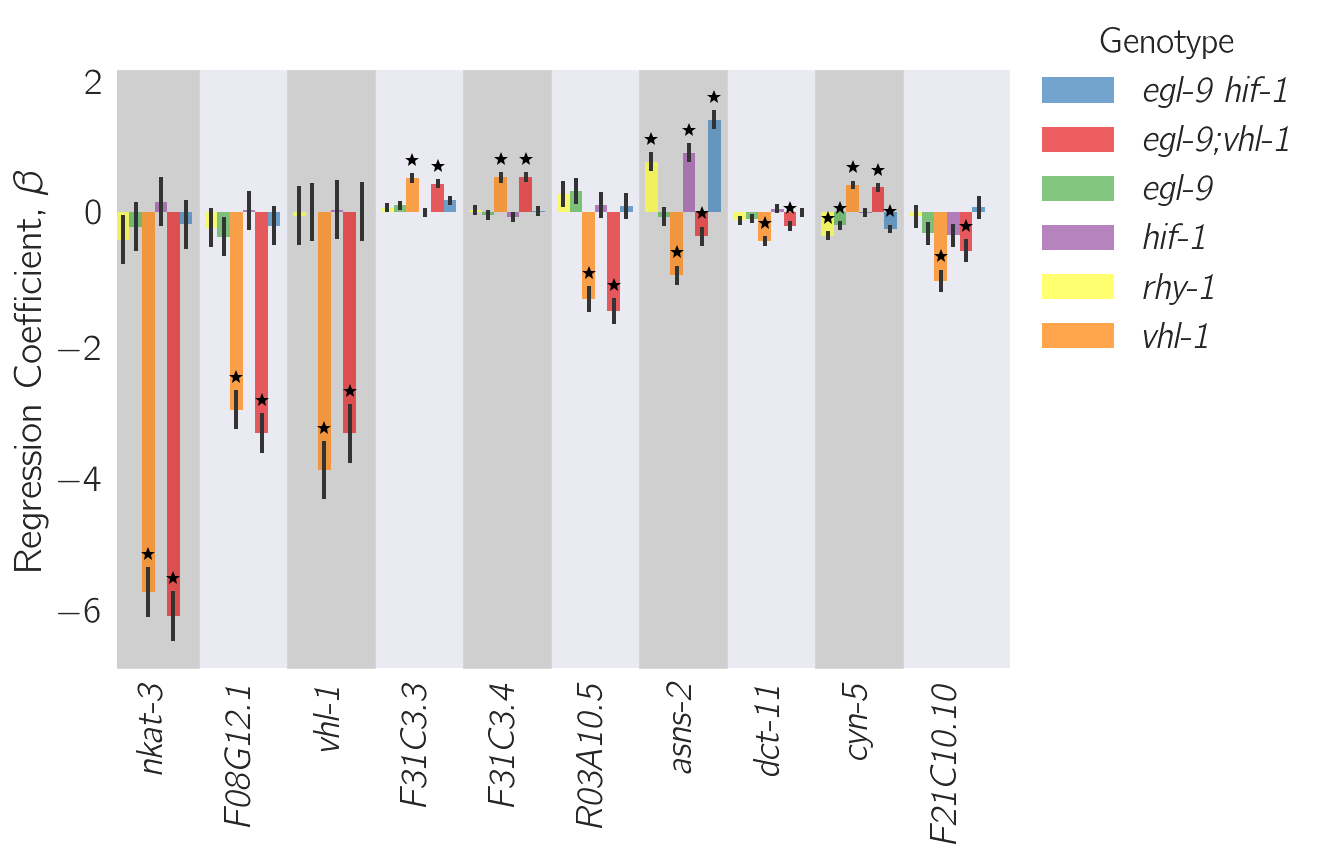

In [12]:
# begin plotting
names = vhl_regulated.sort_values('qval').target_id.unique()[0:10]
name_sort = {}
for i, name in enumerate(names):
    name_sort[name] = i+1

plot_df = tidy_data[tidy_data.target_id.isin(names)].copy()
plot_df['order'] = plot_df.target_id.map(name_sort)
plot_df.sort_values('order', inplace=True)
plot_df.reset_index(inplace=True)  

genpy.qPCR_plot(plot_df, genvar.plot_order, genvar.plot_color,
                clustering='fancy genotype', plotting_group='target_id',
                rotation=90)

# save to file
cols = ['ext_gene', 'ens_gene', 'target_id', 'b', 'qval']
vhl_regulated[cols].to_csv('../output/temp_files/vhl_1_regulated_genes.csv')

No enrichment was observed for these genes.